In [44]:
# Mount on Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Preprocess Action-Effect Data

In [45]:
!pip install datasets
!pip install sklearn
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from datasets import load_dataset

dataset = load_dataset("sled-umich/Action-Effect")['ActionEffect']
print(dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['verb noun', 'effect_sentence_list', 'effect_phrases_list', 'positive_image_list', 'negative_image_list'],
    num_rows: 140
})


### Create text queries and dataset

In [47]:
import numpy as np
import random
import pandas as pd

In [48]:
def create_action_query(verb, noun):
  return "Someone has %s %s." % (verb, noun)

action_queries = [] # text queries
effect_vn = [] # corresponding verb+noun pairs (action texts) for effect texts
effect_texts = [] # all effect texts

nouns = []
verbs = []

min_matches = 20

for i, example in enumerate(dataset):
  # Create text query
  action_text = example['verb noun']
  verb, noun = action_text.split()[0], action_text.split()[1]

  action_query = create_action_query(verb, noun)
  action_queries.append({'query_text': action_query,
                         'query_vn': action_text,
                        })

  effect_doc = ""
  for effect_sent in example['effect_sentence_list']:
    effect_doc += effect_sent + '. '

  effect_vn.append(action_text)
  effect_texts.append(effect_doc)

docno = map(str, np.arange(len(effect_texts)))
doc_dict = {
    'docno': docno,
    'text': effect_texts,
    'effect_vn': effect_vn,
}

doc_df = pd.DataFrame(doc_dict)


In [49]:
doc_df

,docno,text,effect_vn
0,0,chairs are moved around in order. the chairs a...,arrange chairs
1,1,the flowers are in a pretty design. flowers ar...,arrange flowers
2,2,i put a potato in the oven to bake it. the pot...,bake potato
3,3,the eggs are stirred. the eggs are scrambled. ...,beat eggs
4,4,my knee needs surgery. a knee is folding in tw...,bend knee
...,...,...,...
135,135,the tree looks festive for the holiday. the tr...,trim tree
136,136,the hair is turned around on itself. the hair ...,twist hair
137,137,the rope is being contorted. the rope is being...,twist rope
138,138,the book is concealed behind wrapping paper to...,wrap book


### Create topics and qrels
topics:  pandas.Dataframe with columns=[‘qid’, ‘query’]  
qrels: pandas.Dataframe with columns=[‘qid’,’docno’, ‘label’]

In [50]:
qids = []
queries = []
query_vn = []

for qid, q in enumerate(action_queries):
  qids.append(qid)
  queries.append(q['query_text'])
  query_vn.append(q['query_vn'])

qids = map(str, qids)
original_query_df = pd.DataFrame({'qid': qids, 
                       'query': queries,
                       'query_vn': query_vn,})

original_query_df

,qid,query,query_vn
0,0,Someone has arrange chairs.,arrange chairs
1,1,Someone has arrange flowers.,arrange flowers
2,2,Someone has bake potato.,bake potato
3,3,Someone has beat eggs.,beat eggs
4,4,Someone has bend knee.,bend knee
...,...,...,...
135,135,Someone has trim tree.,trim tree
136,136,Someone has twist hair.,twist hair
137,137,Someone has twist rope.,twist rope
138,138,Someone has wrap book.,wrap book


In [51]:
original_topics = original_query_df[['qid', 'query']].copy()

In [52]:
full_qrels = original_query_df.merge(doc_df, 'cross')

In [53]:
full_qrels.head(10)

,qid,query,query_vn,docno,text,effect_vn
0,0,Someone has arrange chairs.,arrange chairs,0,chairs are moved around in order. the chairs a...,arrange chairs
1,0,Someone has arrange chairs.,arrange chairs,1,the flowers are in a pretty design. flowers ar...,arrange flowers
2,0,Someone has arrange chairs.,arrange chairs,2,i put a potato in the oven to bake it. the pot...,bake potato
3,0,Someone has arrange chairs.,arrange chairs,3,the eggs are stirred. the eggs are scrambled. ...,beat eggs
4,0,Someone has arrange chairs.,arrange chairs,4,my knee needs surgery. a knee is folding in tw...,bend knee
5,0,Someone has arrange chairs.,arrange chairs,5,the tree moves over. tree is moved from positi...,bend tree
6,0,Someone has arrange chairs.,arrange chairs,6,the hair is now tied and lifted off of her nec...,bind hair
7,0,Someone has arrange chairs.,arrange chairs,7,putting my teeth on the apple and chewing. the...,bite apple
8,0,Someone has arrange chairs.,arrange chairs,8,a door is obstructed. the door is being surrou...,block door
9,0,Someone has arrange chairs.,arrange chairs,9,the window can not be seen through. an object ...,block window


In [54]:
full_qrels.shape[0]

19600

The qrels is then human annotated and we will load the annotated data directly.

In [55]:
%cd /content/drive/MyDrive/SLED/Action_Effect_Data/

/content/drive/MyDrive/SLED/Action_Effect_Data


In [56]:
# load full qrels with labels
full_qrels = pd.read_csv('annotated_new.csv')

In [57]:
full_qrels.head(10)

,Unnamed: 0,qid,query,query_vn,docno,text,effect_vn,label
0,0,0,Someone has arrange chairs.,arrange chairs,0,chairs are moved around in order. the chairs a...,arrange chairs,5
1,1,0,Someone has arrange chairs.,arrange chairs,1,the flowers are in a pretty design. flowers ar...,arrange flowers,4
2,2,0,Someone has arrange chairs.,arrange chairs,2,i put a potato in the oven to bake it. the pot...,bake potato,1
3,3,0,Someone has arrange chairs.,arrange chairs,3,the eggs are stirred. the eggs are scrambled. ...,beat eggs,1
4,4,0,Someone has arrange chairs.,arrange chairs,4,my knee needs surgery. a knee is folding in tw...,bend knee,1
5,5,0,Someone has arrange chairs.,arrange chairs,5,the tree moves over. tree is moved from positi...,bend tree,1
6,6,0,Someone has arrange chairs.,arrange chairs,6,the hair is now tied and lifted off of her nec...,bind hair,1
7,7,0,Someone has arrange chairs.,arrange chairs,7,putting my teeth on the apple and chewing. the...,bite apple,1
8,8,0,Someone has arrange chairs.,arrange chairs,8,a door is obstructed. the door is being surrou...,block door,2
9,9,0,Someone has arrange chairs.,arrange chairs,9,the window can not be seen through. an object ...,block window,1


### Relevance Score Distribution

In [58]:
!pip install matplotlib 
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
qrels = full_qrels[['qid', 'docno', 'label']].copy()
qrels['qid'] = qrels['qid'].apply(str)
qrels['docno'] = qrels['docno'].apply(str)
print(qrels.dtypes)

qid      object
docno    object
label     int64
dtype: object


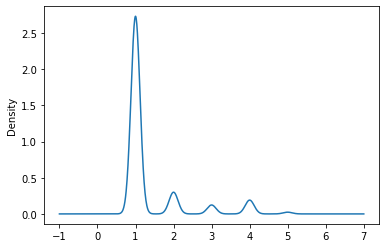

In [60]:
import matplotlib
qrels['label'].plot(kind='kde')

In [61]:
qrels['label'].value_counts().to_dict()

{1: 15886, 2: 1746, 4: 1110, 3: 718, 5: 140}

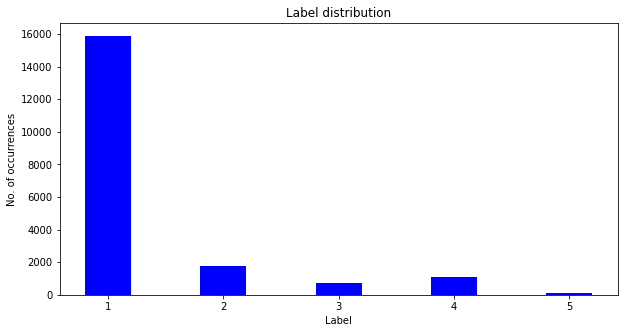

In [62]:
import numpy as np
import matplotlib.pyplot as plt
 

# creating the dataset
data = qrels['label'].value_counts().to_dict()
labels = list(data.keys())
counts = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, counts, color ='blue',
        width = 0.4)
 
plt.xlabel("Label")
plt.ylabel("No. of occurrences")
plt.title("Label distribution")
plt.show()

### Split queries into train, val, test sets (0.6, 0.2, 0.2)

In [63]:
!pip3 install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
SEED=42
from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(original_topics, test_size=0.2, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=0.5, random_state=SEED)

## Indexing action-effect dataset

In [65]:
!pip install python-terrier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import pyterrier as pt
import pandas as pd
import os

if not pt.started():
    pt.init()

In [67]:
!rm -rvf './action_effect_index'

removed './action_effect_index/data.direct.bf'
removed './action_effect_index/data.document.fsarrayfile'
removed './action_effect_index/data.meta.zdata'
removed './action_effect_index/data.meta.idx'
removed './action_effect_index/data.properties'
removed './action_effect_index/data.meta-0.fsomapfile'
removed './action_effect_index/data.inverted.bf'
removed './action_effect_index/data.lexicon.fsomapfile'
removed './action_effect_index/data.lexicon.fsomapid'
removed './action_effect_index/data.lexicon.fsomaphash'
removed directory './action_effect_index'


In [68]:
# create index dir
index_dir = './action_effect_index'

if not os.path.exists(index_dir + "/data.properties"):
    # create the index, using the IterDictIndexer indexer 
    indexer = pt.DFIndexer(index_dir, overwrite=True, blocks=True)
    index_ref = indexer.index(doc_df['text'], doc_df['docno'])
else:
    # if you already have the index, create an IndexRef from the data in pt_index_path
    # that we can use to load using the IndexFactory
    index_ref = pt.IndexRef.of(index_dir + "/data.properties")

index = pt.IndexFactory.of(index_ref)

## Baseline models
We will compute map, nDCG, nDCG@5, nDCG@10 for evaluation.

#### BM25, TF-IDF and Random Selection

In [69]:
import numpy as np

# Returns a random real number in [1, 5]
def random_selection(keyFreq, posting, entryStats, collStats):
  return np.random.uniform(1,5)

In [70]:
print(original_topics.head())
print(original_topics.dtypes)

  qid                         query
0   0   Someone has arrange chairs.
1   1  Someone has arrange flowers.
2   2      Someone has bake potato.
3   3        Someone has beat eggs.
4   4        Someone has bend knee.
qid      object
query    object
dtype: object


In [71]:
print(qrels.head())
print(qrels.dtypes)

  qid docno  label
0   0     0      5
1   0     1      4
2   0     2      1
3   0     3      1
4   0     4      1
qid      object
docno    object
label     int64
dtype: object


In [72]:
from pyterrier.measures import nDCG

random_model = pt.BatchRetrieve(index, wmodel=random_selection)
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
IFB2 = pt.BatchRetrieve(index, wmodel="IFB2")
LGD = pt.BatchRetrieve(index, wmodel="LGD")


pt.Experiment(
    [random_model, bm25, tf_idf, IFB2, LGD],
    original_topics,
    qrels,
    names = ['random', 'bm25', 'tf-idf', 'ifb2', 'lgd'],
    eval_metrics=["map", "ndcg", nDCG@5, nDCG@10])

,name,map,ndcg,nDCG@5,nDCG@10
0,random,0.048316,0.196508,0.520689,0.438050
1,bm25,0.048316,0.196708,0.515581,0.438849
2,tf-idf,0.048316,0.196708,0.515581,0.438849
3,ifb2,0.048316,0.196708,0.515581,0.438849
4,lgd,0.048316,0.196708,0.515581,0.438849


## Installing chatGPT

In [101]:
#install python 3.9 and dev utils
#you may not need all the dev libraries, but I haven't tested which aren't necessary.
!sudo apt-get update -y
!sudo apt-get install python3.9 python3.9-dev python3.9-distutils libpython3.9-dev

#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

# install pip
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall

#install colab's dependencies
!python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

# link to the old google package
!ln -s /usr/local/lib/python3.8/dist-packages/google \
       /usr/local/lib/python3.9/dist-packages/google

!python --version
!python -m pip install --upgrade pip

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 264 kB in 1s (263 kB/s)
Reading p

In [102]:
!pip install chatgptpy --upgrade # Need to restart runtime after this

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.0/913.0 kB 66.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 74.5 MB/s eta 0:00:00
  Created wheel f

You need to restart your runtime to make this import work. Then, rerun the input cell for email and password so that the OpenAI account is set. Apparently, my account has been banned or the API has been banned for some reason.

In [ ]:
email = input("Please enter your email account for openAI.")
password = input("Please enter your password for your openAI email account.")

In [7]:
from pychatgpt import Chat, Options

options = Options()

# Track conversation
options.track = True 

# Use a proxy
# options.proxies = 'http://localhost:8080'

# Optionally, you can pass a file path to save the conversation
# They're created if they don't exist
options.chat_log = "chat_log.txt"
options.id_log = "id_log.txt"

# Create a Chat object
chat = Chat(email=email, password=password, options=options) # personal info hidden for submission purpose
answer = chat.ask("How are you?")
print(answer)

>> Tracking conversation enabled.
>> Access Token missing or expired. Attempting to create them...


[OpenAI] Email address: twenfei@umich.edu
[OpenAI] Password: mar**********
[OpenAI] Beginning auth process
[OpenAI][1] Making request to https://chat.openai.com/auth/login


Auth0Exception: ignored

## Improved models (DO NOT RERUN THIS PART)
<ol>
  <li> Generate new hand-engineered prompts in the query with ChatGPT</li>
  <li> Expand the query with the ChatGPT prompts </li>
  <li> Compute a similarity score between the expanded query and the effect texts</li>
  <li> Evaluate the improved model(s) </li>
</lo>

#### Installing CLIP

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

import torch
import clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zceh6ymj
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-zceh6ymj


#### Generate similarity score using CLIP

In [ ]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device

'cuda'

In [ ]:
# Reference: https://stackoverflow.com/questions/73593712/calculating-similarities-of-text-embeddings-using-clip

!pip install -U torch transformers 
    
import torch
from torch.nn import CosineSimilarity
from transformers import CLIPTokenizer, CLIPModel, CLIPTextModel
cossim = CosineSimilarity(dim=0, eps=1e-6)

def dist(v1, v2):
  return cossim(v1, v2)

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

models = [
    'openai/clip-vit-base-patch16',
    'openai/clip-vit-base-patch32',
    'openai/clip-vit-large-patch14',
]

model_id = models[1]

tokenizer = CLIPTokenizer.from_pretrained(model_id)
text_encoder = CLIPTextModel.from_pretrained(model_id).to(torch_device)
model = CLIPModel.from_pretrained(model_id).to(torch_device)

prompts = query_df['query_vn'].tolist()

text_inputs = tokenizer(
    prompts, 
    padding="max_length", 
    return_tensors="pt",
    ).to(torch_device)
text_features = model.get_text_features(**text_inputs)
text_embeddings = torch.flatten(text_encoder(text_inputs.input_ids.to(torch_device))['last_hidden_state'],1,-1)

text_features_sim = []
text_embedding_sim = []

print("\n\nusing text_features")
for i1, label1 in enumerate(prompts):
  for i2, label2 in enumerate(prompts):
      feat_sim = dist(text_features[i1], text_features[i2])
      text_features_sim.append(feat_sim)
      print(f"{label1} <-> {label2} = {feat_sim:.4f}")

print("\n\nusing text_embeddings")
for i1, label1 in enumerate(prompts):
  for i2, label2 in enumerate(prompts):
      emb_sim = dist(text_embeddings[i1], text_embeddings[i2])
      text_embedding_sim.append(emb_sim)
      print(f"{label1} <-> {label2} = {emb_sim:.4f}")

print(len(text_features_sim), len(text_embedding_sim))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.4.mlp.fc1.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.8.mlp.fc2.bias', 'vision_model.encoder.layers.4.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.4.layer_norm1.bias', 'vision_model.encoder.layers.11.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_model.encoder.layers.6.mlp.fc1.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'visio

Streaming output truncated to the last 5000 lines.
shave hair <-> cook potato = 0.6556
shave hair <-> crack bottle = 0.6595
shave hair <-> crack egg = 0.6234
shave hair <-> crack glass = 0.6536
shave hair <-> crack window = 0.6415
shave hair <-> crash car = 0.6522
shave hair <-> crop hair = 0.8007
shave hair <-> cut apple = 0.6585
shave hair <-> cut meat = 0.7071
shave hair <-> cut onion = 0.6679
shave hair <-> cut potato = 0.6663
shave hair <-> cut tree = 0.6630
shave hair <-> cut wood = 0.6941
shave hair <-> fasten door = 0.6490
shave hair <-> fasten window = 0.6507
shave hair <-> fold paper = 0.6808
shave hair <-> fry egg = 0.6748
shave hair <-> fry meat = 0.6835
shave hair <-> fry potato = 0.6685
shave hair <-> grate carrot = 0.6061
shave hair <-> grate potato = 0.6211
shave hair <-> grind meat = 0.7095
shave hair <-> hang bag = 0.6675
shave hair <-> hang shirt = 0.7059
shave hair <-> ignite paper = 0.6277
shave hair <-> ignite wood = 0.6539
shave hair <-> insert key = 0.6386
shave

In [ ]:
text_features_sim = [feat.item() for feat in text_features_sim]
text_embedding_sim = [feat.item() for feat in text_embedding_sim]

In [ ]:
full_qrels['feature_sim'] = text_features_sim
full_qrels['embedding_sim'] = text_embedding_sim

print(full_qrels.head(10))

  qid                        query        query_vn docno  \
0   0  Someone has arrange chairs.  arrange chairs     0   
1   0  Someone has arrange chairs.  arrange chairs     1   
2   0  Someone has arrange chairs.  arrange chairs     2   
3   0  Someone has arrange chairs.  arrange chairs     3   
4   0  Someone has arrange chairs.  arrange chairs     4   
5   0  Someone has arrange chairs.  arrange chairs     5   
6   0  Someone has arrange chairs.  arrange chairs     6   
7   0  Someone has arrange chairs.  arrange chairs     7   
8   0  Someone has arrange chairs.  arrange chairs     8   
9   0  Someone has arrange chairs.  arrange chairs     9   

                                                text        effect_vn  label  \
0  chairs are moved around in order. the chairs a...   arrange chairs      5   
1  the flowers are in a pretty design. flowers ar...  arrange flowers      4   
2  i put a potato in the oven to bake it. the pot...      bake potato      1   
3  the eggs are sti

In [ ]:
full_qrels.to_csv('/content/drive/MyDrive/SLED/Action_Effect_Data/annotated_sim.csv')

#### Generate prompts for queries and documents
Generate hand-engineered prompts for queries and documents. Save it in a csv file for future usage.

In [ ]:
from pychatgpt import Chat, Options

options = Options()

# Track conversation
options.track = True 

# Use a proxy
# options.proxies = 'http://localhost:8080'

# Optionally, you can pass a file path to save the conversation
# They're created if they don't exist
options.chat_log = "chat_log.txt"
options.id_log = "id_log.txt"

# Create a Chat object
chat = Chat(email=email, password=password, options=options) # personal info hidden for submission purpose
answer = chat.ask("How are you?")
print(answer)

In [ ]:
# Prompting template for queries
# TODO: test the return value here
def expand_query(query):
  noun = query.split()[-1][:-1]
  prompt = f"{query} What could happen to the {noun}?"
  answer = chat.ask(prompt)
  print('Question:', prompt)
  print('Answer:', answer)
  return answer

In [ ]:
expand_query('Someone has baked potatoes.')

Question: Someone has baked potatoes. What could happen to the potatoes?
Answer: Once potatoes have been baked, there are several potential outcomes. Here are a few possibilities:

- The potatoes could be eaten as part of a meal or snack.
- The potatoes could be stored in the refrigerator or freezer for later use.
- The potatoes could be mashed or pureed and used as a ingredient in a recipe.
- The potatoes could be sliced and fried to make potato chips or French fries.
- The potatoes could be left out and become stale or spoil.




'Someone has baked potatoes. What could happen to the potatoes?'

In [ ]:
queries = query_df['query'].tolist()
expanded_queries = []

for query in queries:
  answer = expand_query(query)
  expanded_queries.append(answer)

query_df['expanded_query'] = expanded_queries
print(query_df.head(10))

Question: Someone has arrange chairs. What could happen to the chairs?
Answer: As I mentioned in my previous response, there are many possibilities for what could happen to the chairs once they have been arranged. Some potential outcomes include:

- The chairs could be used for their intended purpose, such as providing seating for people at a meeting or event.
- The chairs could be rearranged again, either by the same person or by someone else.
- The chairs could be moved to a different location, such as being stacked and stored in a closet or shed.
- The chairs could be damaged or broken, either accidentally or intentionally.
- The chairs could be left unused for a long period of time, potentially leading to wear and tear from exposure to the elements or other factors.
Question: Someone has arrange flowers. What could happen to the flowers?
Answer: Once flowers have been arranged, there are several potential outcomes. Here are a few possibilities:

- The flowers could be enjoyed as pa

In [ ]:
print(query_df.head(10))

  qid                         query         query_vn  \
0   0   Someone has arrange chairs.   arrange chairs   
1   1  Someone has arrange flowers.  arrange flowers   
2   2      Someone has bake potato.      bake potato   
3   3        Someone has beat eggs.        beat eggs   
4   4        Someone has bend knee.        bend knee   
5   5        Someone has bend tree.        bend tree   
6   6        Someone has bind hair.        bind hair   
7   7       Someone has bite apple.       bite apple   
8   8       Someone has block door.       block door   
9   9     Someone has block window.     block window   

                                      expanded_query  
0  Someone has arrange chairs. What could happen ...  
1  Someone has arrange flowers. What could happen...  
2  Someone has bake potato. What could happen to ...  
3  Someone has beat eggs. What could happen to th...  
4  Someone has bend knee. What could happen to th...  
5  Someone has bend tree. What could happen to th... 

In [ ]:
for i, query in enumerate(queries):
  if query == 'Someone has pitch baseball.':
    print(i)
    break

95


In [ ]:
expanded_queries_2 = []
for i, query in enumerate(queries):
  if i <= 95:
    continue
  answer = expand_query(query)
  expanded_queries_2.append(answer)

Question: Someone has ride bicycle. What could happen to the bicycle?
Answer: ('It is difficult for me to provide a specific answer to your question without more context. In general, there are many things that could happen to a bicycle if someone is riding it. For example, the bicycle could encounter rough terrain or obstacles in the road, which could cause the rider to lose control and potentially damage the bicycle or cause an accident. Additionally, the bicycle could suffer mechanical issues, such as a flat tire or a malfunctioning chain, which could cause the rider to stop and repair the bicycle or seek assistance. It is also possible that the rider could simply stop riding the bicycle and park it, in which case the bicycle would not experience any significant changes or events.', '72226f74-f31b-48fc-9b5c-0a09a0fe37f1', '5f470ee4-fe9e-4fc4-b001-d168a42e38b6')
Question: Someone has rip paper. What could happen to the paper?
Answer: ('If someone rips paper, the paper will likely be t

#### Processing generated prompts and add to dataframe

In [ ]:
%cd /content/drive/MyDrive/SLED/Action_Effect_Data/
%pwd

/content/drive/MyDrive/SLED/Action_Effect_Data


'/content/drive/MyDrive/SLED/Action_Effect_Data'

In [ ]:
with open('chat_log_1.txt') as f:
  lines = f.read().splitlines() 

lines = lines[2:] # remove the testing QA
chat_answers_1 = []
current_answer = ""
for line in lines:
  if 'Chat GPT: ' in line:
    chat_answers_1.append(current_answer)
    current_answer = ""
    continue

  if '- ' in line:
    current_answer += line[1:]

expanded_queries_1 = chat_answers_1[4: ] # remove redundant testing QA

print(expanded_queries_1[0])
print(expanded_queries_1[1])

 The chairs could be used for their intended purpose, such as providing seating for people at a meeting or event. The chairs could be rearranged again, either by the same person or by someone else. The chairs could be moved to a different location, such as being stacked and stored in a closet or shed. The chairs could be damaged or broken, either accidentally or intentionally. The chairs could be left unused for a long period of time, potentially leading to wear and tear from exposure to the elements or other factors.
 The flowers could be enjoyed as part of the arrangement. The flowers could be given as a gift to someone else. The flowers could be watered and cared for to keep them fresh for as long as possible. The flowers could be dried and preserved to create a permanent keepsake. The flowers could be left to wilt and eventually die if they are not cared for properly.


In [ ]:
with open('chat_log_2.txt') as f:
  lines = f.read().splitlines() 

lines = lines[2:] # remove the testing QA
chat_answers_2 = []
for line in lines:
  if 'Chat GPT: ' in line:
    chat_answers_2.append(line.split(': ')[1])

expanded_queries_2 = chat_answers_2

print(expanded_queries_2[0])
print(expanded_queries_2[1])
print(expanded_queries_2[2])

It is difficult for me to provide a specific answer to your question without more context. In general, there are many things that could happen to a bicycle if someone is riding it. For example, the bicycle could encounter rough terrain or obstacles in the road, which could cause the rider to lose control and potentially damage the bicycle or cause an accident. Additionally, the bicycle could suffer mechanical issues, such as a flat tire or a malfunctioning chain, which could cause the rider to stop and repair the bicycle or seek assistance. It is also possible that the rider could simply stop riding the bicycle and park it, in which case the bicycle would not experience any significant changes or events.
If someone rips paper, the paper will likely be torn along the line where it was ripped. The resulting pieces of paper will be shorter and narrower than the original piece of paper. Depending on the force with which the paper was ripped and the type of paper, the ripped pieces of paper

In [ ]:
expanded_queries = expanded_queries_1 + expanded_queries_2
for query in expanded_queries.copy():
  if query == '':
    expanded_queries.remove(query)
    
print(expanded_queries)
print(len(expanded_queries))

[' The chairs could be used for their intended purpose, such as providing seating for people at a meeting or event. The chairs could be rearranged again, either by the same person or by someone else. The chairs could be moved to a different location, such as being stacked and stored in a closet or shed. The chairs could be damaged or broken, either accidentally or intentionally. The chairs could be left unused for a long period of time, potentially leading to wear and tear from exposure to the elements or other factors.', ' The flowers could be enjoyed as part of the arrangement. The flowers could be given as a gift to someone else. The flowers could be watered and cared for to keep them fresh for as long as possible. The flowers could be dried and preserved to create a permanent keepsake. The flowers could be left to wilt and eventually die if they are not cared for properly.', ' The potato could be eaten as part of a meal or snack. The potato could be stored in the refrigerator or fr

In [ ]:
import pandas as pd

for query in expanded_queries:
  query = query.replace("'","")

query_df = pd.read_csv('expanded_queries.csv')
query_df['expanded_query'] = expanded_queries
print(query_df.head(10))

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  qid  \
0           0             0               0                 0    0   
1           1             1               1                 1    1   
2           2             2               2                 2    2   
3           3             3               3                 3    3   
4           4             4               4                 4    4   
5           5             5               5                 5    5   
6           6             6               6                 6    6   
7           7             7               7                 7    7   
8           8             8               8                 8    8   
9           9             9               9                 9    9   

                          query         query_vn  \
0   Someone has arrange chairs.   arrange chairs   
1  Someone has arrange flowers.  arrange flowers   
2      Someone has bake potato.      bake potato   
3        Someone has 

In [ ]:
query_df.to_csv('expanded_queries.csv')

## Evaluation

In [85]:
# Mount on Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/SLED/Action_Effect_Data/
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SLED/Action_Effect_Data


'/content/drive/MyDrive/SLED/Action_Effect_Data'

In [86]:
annot_df = pd.read_csv('annotated_new.csv') # human annotated labels
query_df = pd.read_csv('expanded_queries.csv') # queries expanded by chatGPT
sim_df = pd.read_csv('qrels_sim.csv') # similarity score calculated with CLIP LM

In [87]:
qrels = annot_df[['qid', 'docno', 'label']].copy()
qrels['qid'] = qrels['qid'].apply(str)
qrels['docno'] = qrels['docno'].apply(str)
print(qrels.dtypes)

qid      object
docno    object
label     int64
dtype: object


In [88]:
query_df['new_query'] = query_df['query'] + query_df['expanded_query'] 
topics = query_df[['qid', 'new_query']].copy()
topics.rename(columns={'new_query': 'query'}, inplace=True)
topics['qid'] = topics['qid'].apply(str)
print(topics.head())

  qid                                              query
0   0  Someone has arrange chairs. The chairs could b...
1   1  Someone has arrange flowers. The flowers could...
2   2  Someone has bake potato. The potato could be e...
3   3  Someone has beat eggs. The eggs could be cooke...
4   4  Someone has bend knee. The knee could move smo...


In [89]:
# handle edge cases
queries = topics['query'].tolist()
for i, query in enumerate(queries):
  queries[i] = ''.join([c for c in query if c != "'"])

print(queries[106])
topics['query'] = queries

Someone has shut window.If someone shuts a window, they will likely be closing the window by moving the sashes or panels of the window in the direction of the window frame until the opening is completely covered. This can cause the window to be in a closed position, blocking access to the outside and preventing drafts or other external factors from entering the space through the window. Depending on the type of window and the method used to shut it, the window may be closed gently or with force, which can affect the windows movement and the amount of noise it makes when it is shut. Additionally, shutting the window may also cause the window to make contact with the window frame or the wall, which can produce a slamming or thudding sound. In general, shutting a window can prevent or restrict access to the outside, and can also produce various sounds and movements.


#### Experiement with expanded query

In [90]:
from pyterrier.measures import nDCG

random_model = pt.BatchRetrieve(index, wmodel=random_selection)
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
IFB2 = pt.BatchRetrieve(index, wmodel="IFB2")
LGD = pt.BatchRetrieve(index, wmodel="LGD")


pt.Experiment(
    [random_model, bm25, tf_idf, IFB2, LGD],
    original_topics,
    qrels,
    names = ['random', 'bm25', 'tf-idf', 'ifb2', 'lgd'],
    eval_metrics=["map", "ndcg", nDCG@5, nDCG@10])

,name,map,ndcg,nDCG@5,nDCG@10
0,random,0.048316,0.195312,0.511819,0.433060
1,bm25,0.048316,0.196708,0.515581,0.438849
2,tf-idf,0.048316,0.196708,0.515581,0.438849
3,ifb2,0.048316,0.196708,0.515581,0.438849
4,lgd,0.048316,0.196708,0.515581,0.438849


In [91]:
from pyterrier.measures import nDCG

random_model = pt.BatchRetrieve(index, wmodel=random_selection)
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
IFB2 = pt.BatchRetrieve(index, wmodel="IFB2")
LGD = pt.BatchRetrieve(index, wmodel="LGD")


pt.Experiment(
    [random_model, bm25, tf_idf, IFB2, LGD],
    topics,
    qrels,
    names = ['random', 'bm25', 'tf-idf', 'ifb2', 'lgd'],
    eval_metrics=["map", "ndcg", nDCG@5, nDCG@10])

,name,map,ndcg,nDCG@5,nDCG@10
0,random,0.499133,0.633680,0.695693,0.687009
1,bm25,0.499133,0.678315,0.901208,0.871388
2,tf-idf,0.499133,0.678915,0.904832,0.874686
3,ifb2,0.499133,0.675936,0.893295,0.861041
4,lgd,0.499133,0.679192,0.907916,0.874060


#### Experiment with CLIP sim score

In [92]:
print(sim_df.head())

   Unnamed: 0  qid                        query        query_vn  docno  \
0           0    0  Someone has arrange chairs.  arrange chairs      0   
1           1    0  Someone has arrange chairs.  arrange chairs      1   
2           2    0  Someone has arrange chairs.  arrange chairs      2   
3           3    0  Someone has arrange chairs.  arrange chairs      3   
4           4    0  Someone has arrange chairs.  arrange chairs      4   

                                                text        effect_vn  label  \
0  chairs are moved around in order. the chairs a...   arrange chairs      5   
1  the flowers are in a pretty design. flowers ar...  arrange flowers      4   
2  i put a potato in the oven to bake it. the pot...      bake potato      1   
3  the eggs are stirred. the eggs are scrambled. ...        beat eggs      1   
4  my knee needs surgery. a knee is folding in tw...        bend knee      1   

   feature_sim  embedding_sim  
0     1.000000       1.000000  
1     0.78

In [93]:
def get_feat_sim(row):
  return sim_df.loc[(sim_df['qid'] == int(row['qid'])) & (sim_df['docno'] == int(row['docno'])), 'feature_sim'].iloc[0]

def get_emb_sim(row):
  return sim_df.loc[(sim_df['qid'] == int(row['qid'])) & (sim_df['docno'] == int(row['docno'])), 'embedding_sim'].iloc[0]

In [94]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

# pipeline1 = bm25 >> (
#   pt.transformer.IdentityTransformer()
#   ** pt.apply.doc_score(get_feat_sim)
#  ) # apply feature sim

# pipeline2 = bm25 >> (
#   pt.transformer.IdentityTransformer()
#   ** pt.apply.doc_score(get_emb_sim)
#  ) # apply embedding sim

# pipeline3 = bm25 >> (
#   pt.transformer.IdentityTransformer()
#   ** pt.apply.doc_score(get_feat_sim)
#   ** pt.apply.doc_score(get_emb_sim)
#  ) # apply embedding sim # apply both feature sim and embedding sim


pipeline1 = bm25 >> ( 
    pt.apply.doc_score(get_feat_sim)
 ) # apply feature sim

pipeline2 = bm25 >> (
    pt.apply.doc_score(get_emb_sim)
 ) # apply embedding sim

pipeline3 = bm25 >> (
  pt.apply.doc_score(get_feat_sim)
  >> pt.apply.doc_score(get_emb_sim)
 ) # apply embedding sim # apply both feature sim and embedding sim

In [95]:
from pyterrier.measures import nDCG

random_model = pt.BatchRetrieve(index, wmodel=random_selection)
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

pt.Experiment(
    [random_model, bm25, pipeline1, pipeline2, pipeline3],
    original_topics,
    qrels,
    names = ['random', 'bm25', 'feat_sim', 'emb_sim', 'feat_emb_sim'],
    eval_metrics=["map", "ndcg", nDCG@5, nDCG@10])

,name,map,ndcg,nDCG@5,nDCG@10
0,random,0.048316,0.196705,0.516160,0.441502
1,bm25,0.048316,0.196708,0.515581,0.438849
2,feat_sim,0.048316,0.216491,0.618487,0.503478
3,emb_sim,0.048316,0.217248,0.620505,0.507246
4,feat_emb_sim,0.048316,0.217248,0.620505,0.507246


#### Experiment with both expanded queries and CLIP sim

In [96]:
from pyterrier.measures import nDCG

random_model = pt.BatchRetrieve(index, wmodel=random_selection)
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

pt.Experiment(
    [random_model, bm25, pipeline1, pipeline2, pipeline3],
    topics,
    qrels,
    names = ['random', 'bm25', 'feat_sim', 'emb_sim', 'feat_emb_sim'],
    eval_metrics=["map", "ndcg", nDCG@5, nDCG@10])

,name,map,ndcg,nDCG@5,nDCG@10
0,random,0.499133,0.632961,0.694979,0.687260
1,bm25,0.499133,0.678315,0.901208,0.871388
2,feat_sim,0.499133,0.694904,0.976473,0.938767
3,emb_sim,0.499133,0.692274,0.970982,0.923411
4,feat_emb_sim,0.499133,0.692274,0.970982,0.923411


## Interactive

### Enter your query

In [97]:
query = input("Please enter a query describing an action. Example: Someone has opened door.")

Please enter a query describing an action. Example: Someone has opened door.Someone has opened door.


In [98]:
print("Entered query:", query)

Entered query: Someone has opened door.


### Prompt from ChatGPT
Before running this part, please run "Installing ChatGPT" first.

In [9]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.0/770.0 kB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 27.3 MB/s eta 0:00:00


In [10]:
import nltk # Used for pos-tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def gen_prompt(query):
  # Get the verb+noun pair
  action_verb = None
  action_noun = None
  action_text = nltk.word_tokenize(query)
  pos_tag_text = nltk.pos_tag(action_text)

  for i, token in enumerate(pos_tag_text):
    if token[1] in ['VB', 'VBZ', 'VBP', 'VBG']:
      action_verb = token[0]
      for j in range(i+1, len(pos_tag_text)):
        if pos_tag_text[j][1] in ['NN', 'NNS', 'NNP']:
          action_noun = pos_tag_text[j][0]
          break
  
  return f"Someone has {action_verb} {action_noun}. What could happen to the {action_noun}?"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from pychatgpt import Chat, Options

options = Options()

# Track conversation
options.track = True 

# Use a proxy
# options.proxies = 'http://localhost:8080'

# Optionally, you can pass a file path to save the conversation
# They're created if they don't exist
options.chat_log = "chat_log.txt"
options.id_log = "id_log.txt"

# Create a Chat object
chat = Chat(email=email, password=password, options=options) # personal info hidden for submission purpose

answer = chat.ask(gen_prompt(query))
print(answer)

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
bm25(answer)
# This should give you a good result given that chatGPT works